In [5]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.power import TTestIndPower
from scipy import stats
%matplotlib inline

Итак, что нужно сделать. У нас есть данные АА-теста с '2021-11-08' по '2021-11-14'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА тестов. На каждой итерации вам нужно сформировать подвыборки с повторением в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом. 

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

In [55]:
# описываем соединение с БД
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}
# описываем sql запрос
q = """SELECT user_id, 
exp_group,
countIf(action='like') likes, 
countIf(action='view') views, 
likes / views ctr
FROM {db}.feed_actions 
where toDate(time) >= '2021-11-08' and toDate(time) <= '2021-11-14' and
exp_group in (2, 3)
group by user_id, exp_group
"""
# берем данные по sql запросу и кладем их df
df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

,user_id,exp_group,likes,views,ctr
0,115383,3,27,160,0.168750
1,10326,3,7,61,0.114754
2,131473,2,16,101,0.158416
3,123580,3,11,72,0.152778
4,23985,2,8,34,0.235294


In [62]:
# оценим с помощью t-test есть ли статистически значимые различия между группами 2 и 3, по метрике ctr
# за нулевую гипотезу примем что между 2 и 3 различий нет
t_test_result=stats.ttest_ind(df[df.exp_group == 2].ctr, df[df.exp_group == 3].ctr, equal_var=False)
t_test_result

Ttest_indResult(statistic=0.2667781493859086, pvalue=0.7896432440544809)

In [ ]:
# pvalue=0.7896432440544809 подтверждает нашу нулевую гипотезу

In [56]:
# проверим нашу гипотезу на множестве эксперементов 
p_values=[]
for i in range(10000):
    # сэмплируем по 500 значений из каждой exp_group
    sample2=df[df.exp_group == 2].sample(n=500, replace=True) 
    sample3=df[df.exp_group == 3].sample(n=500, replace=True)
    # проводим t-test между сэмплами
    t_test_result=stats.ttest_ind(sample2.ctr, sample3.ctr, equal_var=False)
    # добавляем в список результат p-value текущего t-test
    p_values.append(t_test_result[1])
    

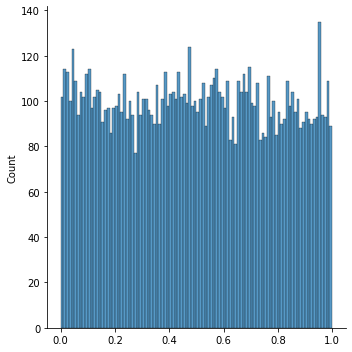

In [58]:
# выводим гистограмму распределения наших 10к p-value 
sns.displot(p_values, bins=100)

In [61]:
# вычисляем процент значений p-value которые меньш чем 0,05
count=0
for i in range(len(p_values)):
    if p_values[i]<0.05: count=count+1
result=count/10000
result

0.0551

## Выводы:
На входе у нас были каким-то образом отсплитованные группы 2 и 3. 'Единичный' t-test этих двух групп показал нам, что между ними нет статистически значимых различий и эти две группы можно смело заряжать на A/B тестирование. Однако есть вероятность того, что нулевая гипотеза не верна, а наше значение p-value мы получили случайным образом попав в 5% хвостов гипотезы 1. Проведя 10000 t-test над выборками по 500 значений группы 2 и группы 3 из совокупности, которая для нас считается "отражением" генеральной, мы заключаем что в 5,51% случаев нулевая гипотеза отвергается, а следовательно делаем вывод, что между группами 2 и 3 нет различий. 

P.S. меня немножко смущает +.0051.... насколько это критично !??? получается что не в 95% процентов случаев мы получем, что p-value >0,05 , а в 94,49% случаев
... но ведь здесь речь идет не о результатах p-value A/B теста, а о качестве сплитования. Я бы проделал вручную еще несколько сплитований, прогнал результаты через код выше и если результаты соизмеримы, то все-таки сказал бы - "Проканает".